In [1]:
%pip install jiwer

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = "/content/drive/MyDrive/data"

In [5]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [6]:
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

In [7]:
metadata_df.tail(10)

,0,1,2
13090,LJ050-0269,The essential terms of such memoranda might we...,The essential terms of such memoranda might we...
13091,LJ050-0270,This Commission can recommend no procedures fo...,This Commission can recommend no procedures fo...
13092,LJ050-0271,The demands on the President in the execution ...,The demands on the President in the execution ...
13093,LJ050-0272,and the traditions of the office in a democrac...,and the traditions of the office in a democrac...
13094,LJ050-0273,"The Commission has, however, from its examinat...","The Commission has, however, from its examinat..."
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [8]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
subset_df = metadata_df[["file_name", "transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,transcription,normalized_transcription
0,LJ027-0061,in order to enclose and protect a similar enla...,in order to enclose and protect a similar enla...
1,LJ014-0282,There were two counts in the indictment: one f...,There were two counts in the indictment: one f...
2,LJ013-0263,He was recognized by an ex-policeman who had k...,He was recognized by an ex-policeman who had k...


In [9]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"size of training set: {len(df_train)}")
print(f"size of training set: {len(df_val)}")

size of training set: 11790
size of training set: 1310


In [10]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
                                        )

print(
    f"the vocabulary is: {char_to_num.get_vocabulary()}"
    f"size = {char_to_num.vocabulary_size()}"
)

the vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']size = 31


In [11]:
char_to_num

<StringLookup name=string_lookup, built=False>

In [12]:
frame_length = 256
frame_step = 160
fft_length = 384

def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)

    spectrogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return spectrogram, label

In [13]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(
        (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
    )
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)

validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

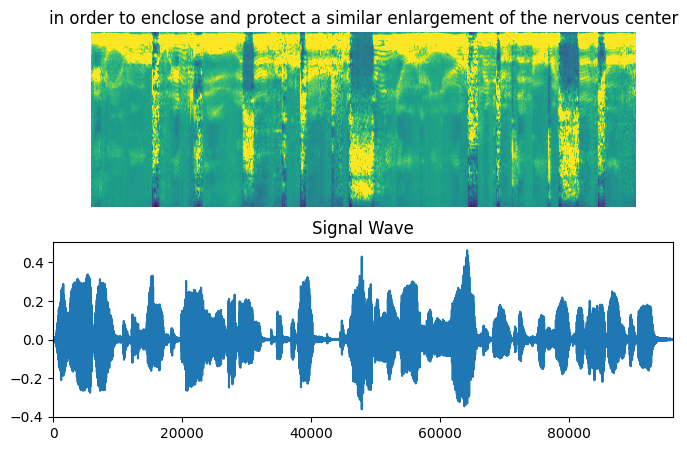

In [14]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [15]:
def CTCLoss(y_true, y_pred):

    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [16]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    input_spectrogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    x = layers.Conv2D(filters=32, kernel_size=[11, 41], strides=[2, 2], padding="same", use_bias=False, name="conv_1")(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.Conv2D(filters=32, kernel_size=[11, 21], strides=[1, 2], padding="same", use_bias=False, name="conv_2")(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units=rnn_units, activation="tanh", recurrent_activation="sigmoid", use_bias=True, return_sequences=True, reset_after=True, name=f"gru_{i}")
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

model = build_model(input_dim=fft_length // 2 + 1, output_dim=char_to_num.vocabulary_size(), rnn_units=512)
model.summary(line_length=110)

Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

In [17]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

class CallbackEval(keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target     : {targets[i]}")
            print(f"Predictions: {predictions[i]}")
            print("-" * 100)


In [ ]:
epochs = 2
validation_callback = CallbackEval(validation_dataset)
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[validation_callback])

Epoch 1/2
  4/369 ━━━━━━━━━━━━━━━━━━━━ 22:51:46 225s/step - loss: 1536.5930

In [18]:
predictions = []
targets = []
for batch in validation_dataset:
    x, y = batch
    batch_predictions = model.predict(x)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = (tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 2):
    print(f"Target     : {targets[i]}")
    print(f"Predictions: {predictions[i]}")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 60s 60s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step
1/1 ━━━━━━━━

In [19]:
def preprocess_audio(file_path):
    file = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)

    spectrogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    spectrogram = tf.expand_dims(spectrogram, axis=0)
    return spectrogram

In [20]:
file_path = "/content/drive/MyDrive/data/testing.wav"
preprocessed_audio = preprocess_audio(file_path)

In [21]:
predictions = model.predict(preprocessed_audio)
decoded_predictions = decode_batch_predictions(predictions)
print("Transcription:", decoded_predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 76s 76s/step
Transcription: evyewewrwrwewryreryweryrwryerywywrwyreweryerwywywyrwrwewewrwrwrwrwrwrwewewewewewewewevyrwrwyewerwrwewrwewrwewerwerwrwrwreweweweweryrwrwerwyerwyerywrewewewewewewrbewerwrewewewrywerwrywewewewewewrywywewewewewewryewewewrwrwrwrwrwrwewewewlwewrwrwrwrwrwrwrwywywrwrwewrwerwryrwrwrwrwpeweywewewewyweweywywrewewewryewewrwryerwrewewrewewewewewerwewewrwewewewewewewlewewrwrwewrwewywewrwewrwewewewewewlewrverwrwewrwewrweweweywewrwrwewewewewrwewewrywywerwewewewewrwyrwrwewerwrweyweyrwewewewywrew
